# Adaptvie scheme *직접* 적용해보기
`TensorFlow`에서 사용하는 `Optimizer`들은 기본적으로 Gradient Descent(=Steepest Descent) Method 기반에서 `learning_rate`과 search direction의 minor variated version 입니다.

예를 들면, 
1. [`tf.train.GradientDescentOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)
1. [`tf.train.AdagradOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/AdagradOptimizer)
1. [`tf.train.AdadeltaOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/AdadeltaOptimizer)
1. [`tf.train.AdamOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)

이번 실습에서는 위와 같은 adaptive scheme의 가장 기본적으로 접근법 중 하나로 `learning_rate` 만을 조정하는 법을 실습해봅니다.

## 실습에서 사용할 예제
주어진 데이터 $(x_i, y_i)$ for $i=1,2, \cdots, 100$에 대하여 아래 loss function을 최소화하는 $a$와 $b$를 구하시오.
\begin{equation}
\min_{w_0,w_1} \frac{1}{100}\sum_{i=1}^{100}|w_0x_i+w_1 - y_i|^2
\end{equation}

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
N = 100
f = lambda x: 0.3 * x + 5.0 # Target function
x_train = np.linspace(-1, 1, N)
np.random.seed(313)
y_train = f(x_train) + 0.2 * np.random.rand(len(x_train))

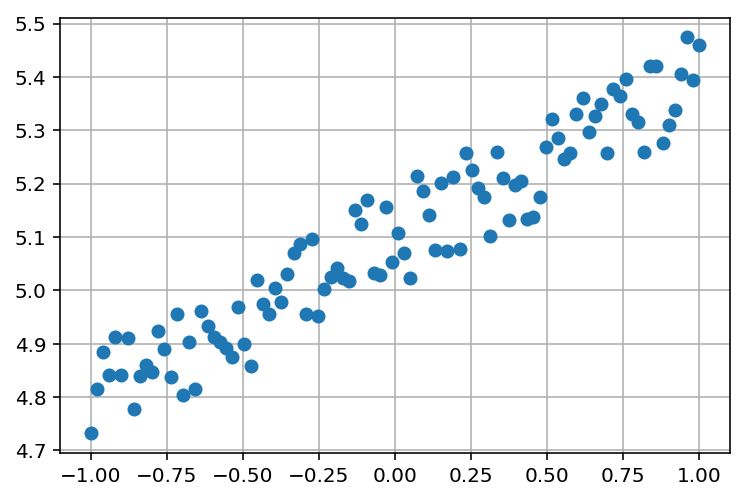

In [3]:
plt.plot(x_train,y_train, 'o')
plt.grid()
plt.show()

### loss function의 input parameter 추가
1. 지금까지는 `loss(w)`로 알 수 있듯이, `w`만 input으로 받고, `data`는 글로벌 변수로 사용했습니다.
1. 관찰해보면 `loss(w)`은 `data`(`x_train`, `y_train`)에 따라서  변하게 됩니다.
1. 그러므로 `loss(w, x_set, y_set)`이 더 정확한 loss function의 표현입니다.
1. 추후 Stochastic Gradient Descent(SGD)에서도 이러한 loss function을 사용합니다.
1. 또한 `TensorFlow`에서도 이러한 방식으로 loss function이 표현됩니다.

In [4]:
def loss(w, x_list, y_list):
    N = len(x_list)
    val = 0.0
    for i in range(N):
        val += (w[0] * x_list[i] + w[1] - y_list[i])**2 / N
    return val

In [5]:
def grad_loss(w, x_list, y_list):
    dim = len(w)
    N = len(x_list)
    val = np.array([0.0, 0.0])
    for i in range(N):
        er = w[0] * x_list[i] + w[1] - y_list[i]
        val += 2.0 * er * np.array([x_list[i], 1.0]) / N
    return val

### learning_rate이 큰 경우
`learning_rate=1.5`로 설정하면, loss function이 계속 커집니다.

In [6]:
w0 = np.array([-5.0, -5.0])
learning_rate = 1.5
MaxIter = 10
for i in range(MaxIter):
    loss0 = loss(w0, x_train, y_train)
    grad = grad_loss(w0, x_train, y_train)
    w1 = w0 - learning_rate * grad
    print(i, w0, loss0)
    w0 = w1

0 [-5. -5.] 111.61270824161771
1 [ 0.40901412 25.30597131] 408.2078823703443
2 [  0.29974111 -35.30597131] 1632.8065117419455
3 [ 0.30194864 85.91791392] 6531.216626793043
4 [   0.30190405 -156.52985654] 26124.85709336312
5 [3.01904947e-01 3.28365684e+02] 104499.41895964617
6 [ 3.01904929e-01 -6.41425397e+02] 417997.66642477794
7 [3.01904930e-01 1.29815677e+03] 1671990.6562853057
8 [ 3.01904930e-01 -2.58100756e+03] 6687962.615727418
9 [3.01904930e-01 5.17732109e+03] 26751850.45349585


### learning_rate이 작은 경우
`learning_rate=0.0001`로 설정하면, loss function이 계속 작아지지만, 너무 느립니다..

In [11]:
w0 = np.array([-5.0, -5.0])
learning_rate = 0.0001
MaxIter = 10
for i in range(MaxIter):
    loss0 = loss(w0, x_train, y_train)
    grad = grad_loss(w0, x_train, y_train)
    w1 = w0 - learning_rate * grad
    print(i, w0, loss0)
    w0 = w1

0 [-5. -5.] 111.61270824161771
1 [-4.9996394 -4.9979796] 111.57059195315173
2 [-4.99927882 -4.99595961] 111.52849216632205
3 [-4.99891827 -4.99394002] 111.48640887457525
4 [-4.99855774 -4.99192083] 111.44434207136058
5 [-4.99819724 -4.98990205] 111.40229175013015
6 [-4.99783676 -4.98788367] 111.36025790433825
7 [-4.99747631 -4.9858657 ] 111.3182405274422
8 [-4.99711588 -4.98384813] 111.27623961290163
9 [-4.99675547 -4.98183096] 111.23425515417895


### 자동으로 learning_rate을 조정하는 아이디어는 없을까?
매번 `learning_rate`을 찾는 것도 피곤한데, 자동으로 찾게 할 방법을 찾아보려합니다. 이번 실습에서는 아래와 같은 방식으로 코드를 작성해봅니다.

1. `loss(w1,x_train,y_train)`가 `loss(w0,x_train,y_train)`보다 커질때마다, `learning_rate`을 2배씩 작게 하고
1. 다시 next position(`w1`)을 업데이트 하고 `loss(w1,x_train,y_train)`을 계산해서 `loss(w0,x_train,y_train)` 값과 비교해봅니다.
1. `loss(w1,x_train,y_train) < loss(w0,x_train,y_train)`이 참값이 될때까지, `learning_rate`를 2배씩 줄입니다.

__`#TODO`안을 채우시면 됩니다.__

__HINT:__
```python
if loss(w1) > loss(w0): # loss(w1) 값이 loss(w0)보다 크다면
    #learning_rate을 줄입니다.
else: # loss(w1) 값이 loss(w0)보다 작다면
    #업데이트 합니다.
```

In [12]:
w0 = np.array([-5.0, -5.0])
learning_rate = 10
MaxIter = 10
for i in range(MaxIter):
    loss0 = loss(w0, x_train, y_train)
    grad = grad_loss(w0, x_train, y_train)
    w1 = w0 - learning_rate * grad
    loss1 = loss(w1, x_train, y_train)
    #TODO
    print(i, w0, loss0)
    w0 = w1

0 [-5. -5.] 111.61270824161771
1 [ 31.06009413 197.03980871] 37161.85544075267
2 [ -178.13701763 -3641.71655686] 13310113.416859973
3 [ 1035.48797755 69294.65438904] 4801406491.23444
4 [   -6005.17150625 -1316496.3935831 ] 1733188452617.7275
5 [   34840.13586944 25013533.5178876 ] 625677016591403.2
6 [-2.02117657e+05 -4.75257035e+08] 2.2586926786877354e+17
7 [1.17255668e+06 9.02988376e+09] 8.153880115305487e+19
8 [-6.80240588e+06 -1.71567791e+11] 2.9435507063201448e+22
9 [3.94631177e+07 3.25978804e+12] 1.0626218044664676e+25


In [27]:
w0 = np.array([-5.0, -5.0])
learning_rate = 10
MaxIter = 10
for i in range(MaxIter):
    loss0 = loss(w0, x_train, y_train)
    grad = grad_loss(w0, x_train, y_train)
    w1 = w0 - learning_rate * grad
    loss1 = loss(w1, x_train, y_train)
    if loss(w1,x_train,y_train) > loss(w0,x_train,y_train):
        learning_rate /= 2.0
    else:
         w0 = w1
    print(i, w0, loss0)   

0 [-5. -5.] 111.61270824161771
1 [-5. -5.] 111.61270824161771
2 [-5. -5.] 111.61270824161771
3 [-5. -5.] 111.61270824161771
4 [-2.74624412  7.62748804] 111.61270824161771
5 [-1.45052419  4.47061603] 9.540914065869524
6 [-0.70559431  5.25983404] 1.4461210362118477
7 [-0.27732232  5.06252954] 0.3732394925294415
8 [-0.03110198  5.11185566] 0.11878912294074132
9 [0.11045398 5.09952413] 0.040946551456975545
